#### Notes on current version:
**Done**:

- $\checkmark$ Cayley parameterization](https://planetmath.org/cayleysparameterizationoforthogonalmatrices) of $SU_d$ (since this is really all we need)...*will it be more stable than Lie's parameterization?* Note: it is a homeomorphism so this is great for UAP!

**To do:**
  
- Implement Regression

- Implement Feature Map

# NEU (Reconfigurations Map and Related Functions)

### Basic Algorithm (NEU-OLS)

1. Perform Basic Algorithm (in this case OLS)
2. Map predictions to their graph; ie $x\mapsto (x,\hat{f}_{OLS}(x))$ where $\hat{f}_{OLS}$ is the least-squares regression function.

## Initializations:

In [1]:
# Data Structuring
import numpy as np
import pandas as pd


# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.special import expit

# Regression
from sklearn.linear_model import LinearRegression
from scipy import linalg as scila

# Tensorflow
import tensorflow as tf
import keras as K
import keras.backend as Kb
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam

# Operating-System Related
import os
from pathlib import Path

# Visualization
from matplotlib.pyplot import figure

# z_Misc
import time
import math

Using TensorFlow backend.


## Check/Make Paths

In [2]:
Path('./outputs/models/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Linear_Regression/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/Base_Regressor/').mkdir(parents=True, exist_ok=True)
Path('./outputs/tables/').mkdir(parents=True, exist_ok=True)
Path('./outputs/results/').mkdir(parents=True, exist_ok=True)
Path('./inputs/data/').mkdir(parents=True, exist_ok=True)

## Initialize Internal Variables/(Hyper)parameter(s)

In [3]:
# Robustness Parameter
robustness_parameter = .1

# Reconfiguration Parameters
N_Reconfigurations = 10
d = 1 # Dimension of X
D = 1 # Dimension of Y


# Data Meta-Parameters
noise_level = 1

# Training meta-parameters
Pre_Epochs = 50
Full_Epochs = 50

# Depth & Height of first Reconfiguration
Initial_Depth = 10
Initial_Height = 5

# Depth & Height Per Reconfiguration
Depth_per_reconfig = 10
Height_per_reconfig = 5

# Number of Datapoints
N_data = 10**3

# Unknown Function
def unknown_f(x):
    return .1*x + .1*(x**2) + np.exp(-np.abs(x)) + np.sin(4*x + x% 2) + x % 1

### Run External/Auxiliary Notebooks

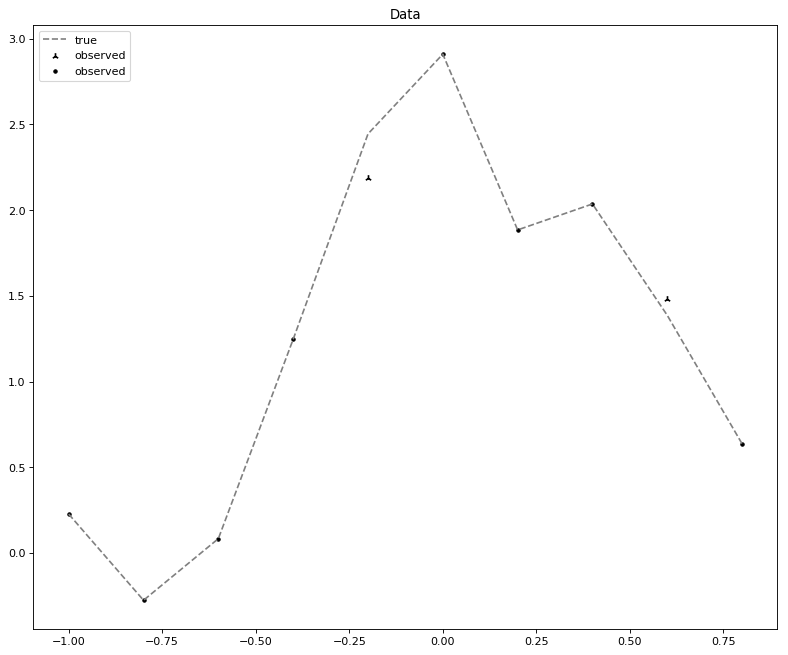

In [4]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
%run Data_Generator.ipynb
# Import Custom Layer(s)
%run Special_Layers_Homeomorphic.ipynb
# Import Utility for NEU
%run NEU_Util.ipynb
# Import Benchmarks
%run Benchmarks_Util.ipynb

#### Prepare data for NEU

## 1) Get Basic Regression Models
 1. Get Base regression model (benchmark),
 2. Get Base regression model for NEU.

## Get basic regression model - Benchmark

In [5]:
if os.path.exists('./outputs/models/Benchmarks/Linear_Regression/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Benchmark model - already exists: Loading...')
    regression_Benchmark = tf.keras.models.load_model("./outputs/models/NEU/Greedy_Initializations/")
    print('Benchmark model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_Benchmark = def_model_Regression(data_x,
                                                data_y,
                                                Pre_Epochs_in=200,
                                                height=100,
                                                depth=10,
                                                learning_rate=0.01)
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Benchmark-Model: Saving')
    regression_Benchmark.save("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS_Benchmark =  regression_Benchmark.predict(data_x)
predictions_OLS_Benchmark_test =  regression_Benchmark.predict(data_x_test)

Benchmark model - already exists: Loading...
Benchmark model - already exists: Loaded.


## Get base regression model for NEU

In [6]:
if os.path.exists('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Base Regressor model - already exists: Loading...')
    regression_basic = tf.keras.models.load_model('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/', custom_objects={'Robust_MSE': Robust_MSE})
    print('Base Regressor model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_basic = get_base_model_Regression(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=200, 
                                             height=100, 
                                             depth=10,
                                             learning_rate=0.01)
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Base Regressor-Model: Saving')
    regression_basic.save("./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/")
    print('Base Regressor-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS = regression_basic.predict(data_x)
predictions_OLS_test = regression_basic.predict(data_x_test)

Base Regressor model - already exists: Loading...
Base Regressor model - already exists: Loaded.


### Generate Plots - Visualization

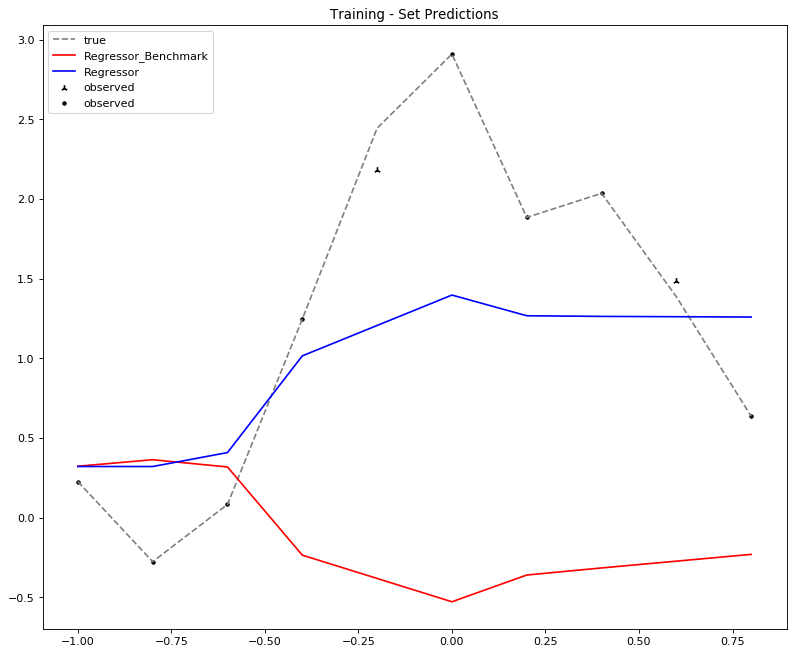

In [34]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='true',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='observed', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='observed', marker = '.')


# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test[:,1]), color = 'red', label='Regressor_Benchmark')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='Regressor')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

## 3) Readout
 1. Get Base Model,
 2. Greedy Layer-Wise Initialization,
 3. Robust SGD on entire structure.
 
We train NEU-OLS, by unfreezing the greedily initialized layers, as per [this paper](https://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf), and using "robust"-SGD on the whole structure.

In [27]:
#----------------------------------#
# Greedy Layer-Wise Initialization #
#----------------------------------#
if os.path.exists("./outputs/models/NEU/Greedy_Initializations/saved_model.pb"):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Pre-trained readout-map already exists: Loading.')
    NEU_OLS_Greedy_init = tf.keras.models.load_model("./outputs/models/NEU/Greedy_Initializations/")
    print('Saved pre-trained readout-map: Loaded.')
    #-----------------#
    # Load Full-Model #
    #-----------------#
    print('Full-model already exists: Loading.')
    NEU_OLS = tf.keras.models.load_model("./outputs/models/NEU/", custom_objects={'Robust_MSE': Robust_MSE})
    print('Full-Model: Loaded')
else:
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                          Pre-Trained Model                                           #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('Pre-trained model does not exist: Training.')
    # Greedy Initialization
    model = regression_basic
    NEU_OLS_Greedy_init = model
    for i in range(N_Reconfigurations):
        # Update Model
        NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                     data_x,
                                                                     data_NEU,
                                                                     Pre_Epochs,
                                                                     Depth_per_reconfig,
                                                                     Height_per_reconfig)

        # Check for Blowup
        if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_x))):
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
            break
        else: #Update Model if not explosion
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp

        #-------------#
        # Update User #
        #-------------#
        print(np.mean(np.abs((NEU_OLS_Greedy_init.predict(data_x) - data_NEU)**2)))
        # Update User on Status of Initialization
        print(((i+1)/N_Reconfigurations))
        
    # Update User of Pre-Training Completion
    print('Complete: Pre-Training Readout Map on Input x Output Space!')
    
    #------------------------------------#
    # Save Greedily Initialized Layer(s) #
    #------------------------------------#
    print('Saving Pre-Trained Readout on Input x Output Space!')
    NEU_OLS_Greedy_init.save("./outputs/models/NEU/Greedy_Initializations/")
    
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                             Full Model                                               #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('(Full-)Model does not exist: Training.')
    NEU_OLS = build_reconfiguration(model_greedy_initialized=NEU_OLS_Greedy_init, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    height = Height_per_reconfig)
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Full-Model: Saving')
    NEU_OLS.save("./outputs/models/NEU/")
    print('Full-Model: Saved')
    

# Make Predictions #
#------------------#
# Predictions Train
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_x)
NEU_OLS_prediction = NEU_OLS.predict(data_x)
# Predictions Test
NEU_OLS_greedy_initializations_test = NEU_OLS_Greedy_init.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS.predict(data_x_test)

    
# Update User #
#-------------#
print('NEU: Ready!')

Pre-trained readout-map already exists: Loading.
Saved pre-trained readout-map: Loaded.
Full-model already exists: Loading.
Full-Model: Loaded
NEU: Ready!


### Generate Plots - Visualization

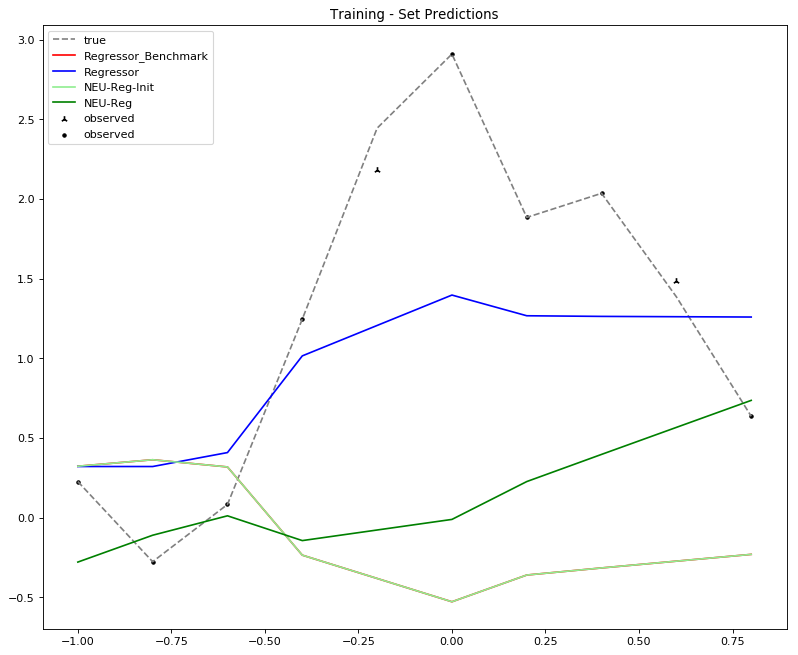

In [37]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='true',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='observed', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='observed', marker = '.')

# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test[:,1]), color = 'red', label='Regressor_Benchmark')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='Regressor')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test.reshape(-1,)), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

---
---
---

# Benchmark Models

In [38]:
#------------------#
# Train GLd-Model  #
#------------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/saved_model.pb"):
    print('GLd-Nets Trained model already exists: Loading.')
    Deep_GLd = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets trained model: Loaded.')
else:
    print('GLd-Nets Model does not exist: Training.')
    Deep_GLd = get_base_model_deep_GLd(data_x,
                                       data_NEU,
                                       Full_Epochs_in = Full_Epochs,
                                       depth = (N_Reconfigurations*Initial_Depth),
                                       height = Height_per_reconfig)
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('GLd-Nets Model: Saving')
    Deep_GLd.save("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets Model: Saved')
    
    
# Predictions Train
Deep_GLd_prediction = Deep_GLd.predict(data_x)
# Predictions Test
Deep_GLd_prediction_test = Deep_GLd.predict(data_x_test)
    
    
# Update User #
#-------------#
print('Benchmark Model - GLd-Nets: Ready!')

GLd-Nets Trained model already exists: Loading.
GLd-Nets trained model: Loaded.
Benchmark Model - GLd-Nets: Ready!


In [39]:
#-----------------#
# Train Ed-Model  #
#-----------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/saved_model.pb"):
    print('Ed-Nets Trained model already exists: Loading.')
    Deep_Ed = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets trained model: Loaded.')
else:
    print('Ed-Nets Model does not exist: Training.')
    Deep_Ed=get_base_model_deep_Euclidean_Networks(data_x,
                                                   data_NEU,
                                                   Full_Epochs_in = Full_Epochs,
                                                   depth = (N_Reconfigurations*Initial_Depth),
                                                   height = Height_per_reconfig)
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('Ed-Nets Model: Saving')
    Deep_Ed.save("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets Model: Saved')
    
    
# Predictions Train
Deep_Ed_prediction = Deep_Ed.predict(data_x)
# Predictions Test
Deep_Ed_prediction_test = Deep_Ed.predict(data_x_test)
    
# Update User #
#-------------#
print('Benchmark Model - Ed-Nets: Ready!')

Ed-Nets Trained model already exists: Loading.
Ed-Nets trained model: Loaded.
Benchmark Model - Ed-Nets: Ready!


## Model Evaluation: 
*Record Error(s)/Prediction Quality*

Test results.

In [42]:
true_y

array([ 0.22675943, -0.27596846,  0.08334065,  1.24632005,  2.44420174,
        2.90929743,  1.88420174,  2.03561747,  1.38593164,  0.63652647])

In [43]:
# Quantile Losses 
# -----------------#
Results_MAE = np.array([np.mean(np.abs(NEU_OLS_prediction  - data_y)),
                        np.mean(np.abs(predictions_OLS[:,1]  - data_y)),
                        np.mean(np.abs(Deep_GLd_prediction[:,1]  - data_y)),
                        np.mean(np.abs(Deep_Ed_prediction[:,1] - data_y))])

Results_MinE = np.array([np.min(np.abs(NEU_OLS_prediction  - data_y)),
                         np.min(np.abs(predictions_OLS[:,1]  - data_y)),
                         np.min(np.abs(Deep_GLd_prediction[:,1]  - data_y)),
                         np.min(np.abs(Deep_Ed_prediction[:,1] - data_y))])

Results_MaxE = np.array([np.max(np.abs(NEU_OLS_prediction  - data_y)),
                         np.max(np.abs(predictions_OLS[:,1]  - data_y)),
                         np.max(np.abs(Deep_GLd_prediction[:,1]  - data_y)),
                         np.max(np.abs(Deep_Ed_prediction[:,1] - data_y))])

# Variance Losses
#----------------#
Results_MSE = np.array([np.mean(np.power(NEU_OLS_prediction  - data_y,2)),
                        np.mean(np.power(predictions_OLS[:,1]  - data_y,2)),
                        np.mean(np.power(Deep_GLd_prediction[:,1]  - data_y,2)),
                        np.mean(np.power(Deep_Ed_prediction[:,1] - data_y,2))])

# Robust Loss
#-------------#
# Robust MAE
Results_rMAE = np.array([Robust_MSE_numpy(NEU_OLS_prediction,data_y),
                         Robust_MSE_numpy(predictions_OLS[:,1],data_y),
                         Robust_MSE_numpy(Deep_GLd_prediction[:,1],data_y),
                         Robust_MSE_numpy(Deep_Ed_prediction[:,1],data_y)])

# Write to DataFrame
Results = pd.DataFrame({'MAE': Results_MAE,
                        'MinE': Results_MinE, 
                        'MaxE': Results_MaxE,
                        'Robust MAE':Results_rMAE,
                        'MSE':Results_MSE},
                        index={'NEU-OLS','OLS','Deep GLd','Deep ED'})

Test results.

In [44]:
# Quantile Losses 
#-----------------#
Results_MAE_test = np.array([np.mean(np.abs(NEU_OLS_prediction_test  - data_y_test)),
                             np.mean(np.abs(predictions_OLS_test[:,1]  - data_y_test)),
                             np.mean(np.abs(Deep_GLd_prediction_test[:,1]  - data_y_test)),
                             np.mean(np.abs(Deep_Ed_prediction_test[:,1] - data_y_test))])

Results_MinE_test = np.array([np.min(np.abs(NEU_OLS_prediction_test  - data_y_test)),
                              np.min(np.abs(predictions_OLS_test[:,1]  - data_y_test)),
                              np.min(np.abs(Deep_GLd_prediction_test[:,1]  - data_y_test)),
                              np.min(np.abs(Deep_Ed_prediction_test[:,1] - data_y_test))])

Results_MaxE_test = np.array([np.max(np.abs(NEU_OLS_prediction_test  - data_y_test)),
                              np.max(np.abs(predictions_OLS_test[:,1]  - data_y_test)),
                              np.max(np.abs(Deep_GLd_prediction_test[:,1]  - data_y_test)),
                              np.max(np.abs(Deep_Ed_prediction_test[:,1] - data_y_test))])

# Variance Losses
#----------------#
Results_MSE_test = np.array([np.mean(np.power(NEU_OLS_prediction_test  - data_y_test,2)),
                             np.mean(np.power(predictions_OLS_test[:,1]  - data_y_test,2)),
                             np.mean(np.power(Deep_GLd_prediction_test[:,1]  - data_y_test,2)),
                             np.mean(np.power(Deep_Ed_prediction_test[:,1] - data_y_test,2))])

# Robust Loss
#-------------#
# Robust MAE
Results_rMAE_test = np.array([Robust_MSE_numpy(NEU_OLS_prediction_test,data_y_test),
                              Robust_MSE_numpy(predictions_OLS_test[:,1],data_y_test),
                              Robust_MSE_numpy(Deep_GLd_prediction_test[:,1],data_y_test),
                              Robust_MSE_numpy(Deep_Ed_prediction_test[:,1],data_y_test)])

# Write to DataFrame
Results_test = pd.DataFrame({'MAE': Results_MAE_test,
                        'MinE': Results_MinE_test, 
                        'MaxE': Results_MaxE_test,
                        'Robust MAE':Results_rMAE_test,
                        'MSE':Results_MSE_test},
                        index={'NEU-OLS','OLS','Deep GLd','Deep ED'})

# Visualize Predictions

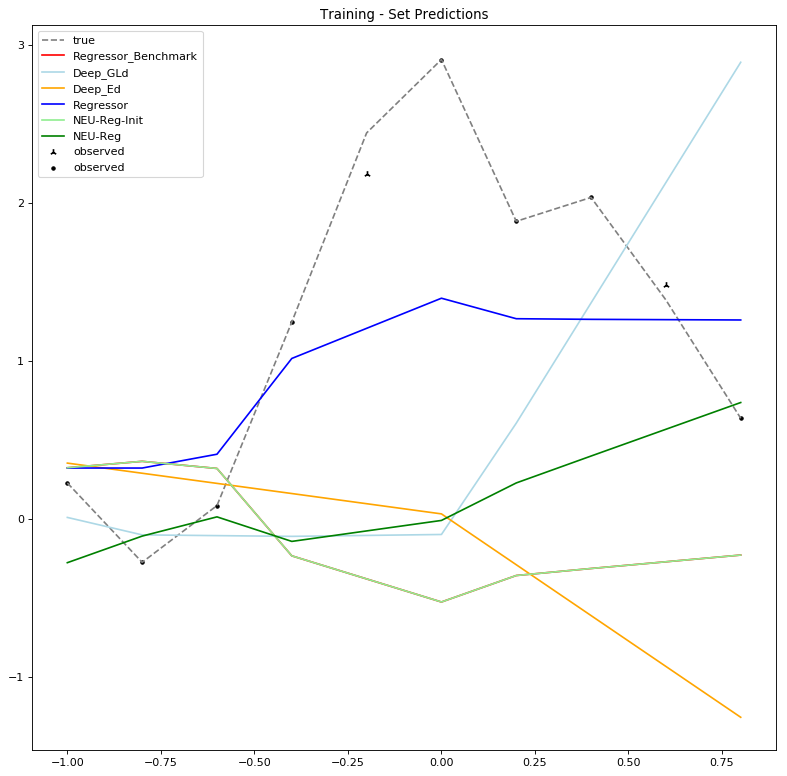

In [46]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='true',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='observed', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='observed', marker = '.')

# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test[:,1]), color = 'red', label='Regressor_Benchmark')
plt.plot(np.array(data_x_test).reshape(-1,),Deep_GLd_prediction_test[:,1],color='lightblue',label='Deep_GLd')
plt.plot(np.array(data_x_test).reshape(-1,),Deep_Ed_prediction_test[:,1],color='orange',label='Deep_Ed')

# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='Regressor')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test.reshape(-1,)), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

 ---

# Report Results

In [47]:
print('Train Results:')
Results

Train Results:


,MAE,MinE,MaxE,Robust MAE,MSE
OLS,1.864921,0.923338,2.806504,1.888515,3.950031
NEU-OLS,0.121999,0.022165,0.221833,0.122497,0.024851
Deep ED,1.473768,0.646687,2.300848,1.507932,2.856053
Deep GLd,2.253960,2.089303,2.418616,2.255315,5.107445


In [48]:
print('Test Results:')
Results_test

Test Results:


,MAE,MinE,MaxE,Robust MAE,MSE
OLS,1.143592,0.000072,3.187661,1.187059,2.162258
NEU-OLS,0.596530,0.094572,1.512200,0.604961,0.522057
Deep ED,1.143935,0.173789,3.008991,1.193179,2.272535
Deep GLd,1.439321,0.125769,2.878471,1.492921,3.144828


#### The END